<a href="https://colab.research.google.com/github/sul01/MSDS-CODE/blob/master/hw3/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#loading
BITSTREAMVERA = pd.read_csv("https://raw.githubusercontent.com/CharlesColgan/MSDS-6350-6373-CODE/master/hw2/BITSTREAMVERA.csv")
CENTURY = pd.read_csv('https://raw.githubusercontent.com/sul01/MSDS-CODE/master/hw3/CENTURY.csv')
CONSOLAS = pd.read_csv("https://raw.githubusercontent.com/CharlesColgan/MSDS-6350-6373-CODE/master/hw2/CONSOLAS.csv")
EBRIMA = pd.read_csv("https://raw.githubusercontent.com/CharlesColgan/MSDS-6350-6373-CODE/master/hw2/EBRIMA.csv")
GILL = pd.read_csv('https://raw.githubusercontent.com/sul01/MSDS-CODE/master/hw3/GILL.csv')

#cleaning
drop_names = ["fontVariant","m_label","orientation","m_top","m_left","originalH","originalW","h","w"]
FONT = [BITSTREAMVERA, CENTURY, CONSOLAS, EBRIMA, GILL]; CL = []
for i in range(5):
  CL.append(FONT[i][(FONT[i]['strength']==0.4) & (FONT[i]['italic']==0)].drop(drop_names,axis=1))

#transforming
def fontToMatrix(font, df):
  for case in range(df.shape[0]):
    font[case] =  np.array(df[df.columns[3:]].iloc[case]).reshape(20,20)

FONT_mat = [] #font as 20x20 matrix
for i in range(5):
  FONT_mat.append(np.empty((CL[i].shape[0],20,20), int))
  fontToMatrix(FONT_mat[i], CL[i])

Examples

Bitstream



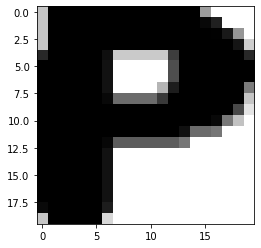

Century



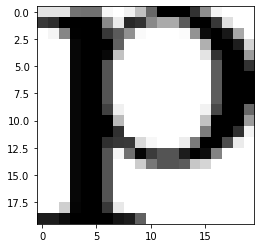

Consolas



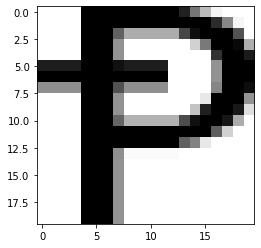

Ebrima



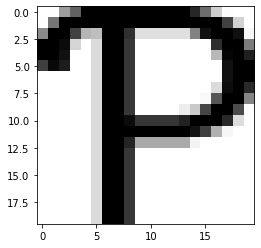

Gill



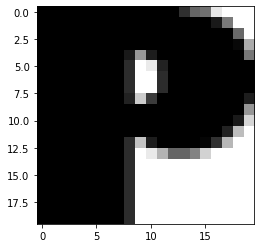

In [2]:
print('Bitstream\n'); plt.imshow(FONT_mat[0][8], cmap=plt.cm.binary); plt.show() 
print('Century\n'); plt.imshow(FONT_mat[1][199], cmap=plt.cm.binary); plt.show() 
print('Consolas\n'); plt.imshow(FONT_mat[2][26], cmap=plt.cm.binary); plt.show() 
print('Ebrima\n'); plt.imshow(FONT_mat[3][1387], cmap=plt.cm.binary); plt.show() 
print('Gill\n'); plt.imshow(FONT_mat[4][243], cmap=plt.cm.binary); plt.show() 

train/test split

In [3]:
from sklearn.model_selection import train_test_split

def ypred(x, model):
  return list(map({0:'BITSTREAMVERA', 1:'CENTURY', 2:'CONSOLAS', 3:'EBRIMA', 4:'GILL'}.get, model.predict(x).argmax(axis = -1)))

dataX = np.concatenate(([FONT_mat[i] for i in range(5)])).reshape(-1,20,20,1)
dataY = np.concatenate(([CL[i]['font'] for i in range(5)]))
train, test = train_test_split(range(dataX.shape[0]), test_size = 0.2, random_state = 0)
x_train = dataX[train]; x_test = dataX[test]
y_train = dataY[train]; y_test = dataY[test]

#CNN

(https://www.tensorflow.org/tutorials/images/cnn)

h=200

In [4]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import ModelCheckpoint

#build (step 3)
model = models.Sequential()
model.add(layers.Conv2D(16, (5, 5), activation='relu', input_shape=(20, 20, 1)))
model.add(layers.MaxPooling2D((2, 2), strides= 2))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides= 2))
model.add(layers.Flatten())
model.add(layers.Dense(200, activation='relu')) 
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))
#model.summary()

checkpointer = ModelCheckpoint('modelh_200', monitor='val_accuracy', save_best_only=True)
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
monitor = model.fit(x_train, tf.one_hot(pd.Series(y_train,dtype='category').astype('category').cat.codes,5), epochs=100, batch_size= int(len(train)**0.5),
                    validation_data=(x_test, tf.one_hot(pd.Series(y_test, dtype='category').astype('category').cat.codes,5)), callbacks=[checkpointer])

Epoch 1/100
89/89 [==============================] - 3s 28ms/step - loss: 16.7791 - accuracy: 0.2762 - val_loss: 1.3628 - val_accuracy: 0.4383
INFO:tensorflow:Assets written to: modelh_200/assets
Epoch 2/100
89/89 [==============================] - 2s 22ms/step - loss: 1.5413 - accuracy: 0.3846 - val_loss: 1.2304 - val_accuracy: 0.5008
INFO:tensorflow:Assets written to: modelh_200/assets
Epoch 3/100
89/89 [==============================] - 2s 23ms/step - loss: 1.3397 - accuracy: 0.4425 - val_loss: 1.1489 - val_accuracy: 0.5351
INFO:tensorflow:Assets written to: modelh_200/assets
Epoch 4/100
89/89 [==============================] - 2s 22ms/step - loss: 1.2392 - accuracy: 0.4933 - val_loss: 1.1144 - val_accuracy: 0.5484
INFO:tensorflow:Assets written to: modelh_200/assets
Epoch 5/100
89/89 [==============================] - 2s 25ms/step - loss: 1.1585 - accuracy: 0.5240 - val_loss: 1.0558 - val_accuracy: 0.5796
INFO:tensorflow:Assets written to: modelh_200/assets
Epoch 6/100
89/89 [=====

Performance during learning

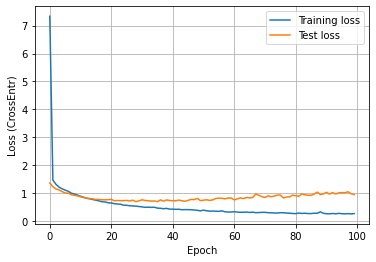

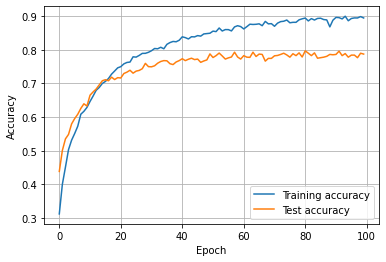

In [5]:
def plotCrssEntr(monitor):
  plt.plot(monitor.model.history.history['loss'], label = 'Training loss')
  plt.plot(monitor.model.history.history['val_loss'], label = 'Test loss')
  plt.xlabel('Epoch'); plt.ylabel('Loss (CrossEntr)')
  plt.legend(); plt.grid(True); plt.show()

def plotAcc(monitor):
  plt.plot(monitor.model.history.history['accuracy'], label = 'Training accuracy')
  plt.plot(monitor.model.history.history['val_accuracy'], label = 'Test accuracy')
  plt.xlabel('Epoch'); plt.ylabel('Accuracy')
  plt.legend(); plt.grid(True); plt.show()

plotCrssEntr(monitor); plotAcc(monitor)

Conf Matirx

In [6]:
def conf(actu, pred):
  y_actu = pd.Series(np.array(actu), name = 'Actual')
  y_pred = pd.Series(pred, name = 'Predicted')
  df_confusion = pd.crosstab(y_actu, y_pred)
  return df_confusion.divide(df_confusion.sum(axis=1),axis=0), sum(np.diag(df_confusion))/sum(np.sum(df_confusion))

trainConf, trainGlobal = conf(y_train, ypred(x_train, monitor.model))
print('Train:\n', trainConf,'\nGlobal: ', trainGlobal)

testConf, testGlobal = conf(y_test, ypred(x_test, monitor.model))
print('\nTest:\n', testConf, '\nGlobal: ', testGlobal)

Train:
 Predicted      BITSTREAMVERA   CENTURY  CONSOLAS    EBRIMA      GILL
Actual                                                              
BITSTREAMVERA       0.992992  0.002695  0.002695  0.000539  0.001078
CENTURY             0.000617  0.987053  0.006165  0.002466  0.003699
CONSOLAS            0.002782  0.029494  0.961603  0.002782  0.003339
EBRIMA              0.000728  0.023290  0.016012  0.954876  0.005095
GILL                0.005168  0.053402  0.012920  0.006891  0.921619 
Global:  0.9672173133563836

Test:
 Predicted      BITSTREAMVERA   CENTURY  CONSOLAS    EBRIMA      GILL
Actual                                                              
BITSTREAMVERA       0.943311  0.006803  0.022676  0.004535  0.022676
CENTURY             0.005305  0.901857  0.047745  0.026525  0.018568
CONSOLAS            0.040984  0.061475  0.760246  0.088115  0.049180
EBRIMA              0.014327  0.177650  0.171920  0.593123  0.042980
GILL                0.093960  0.063758  0.093960  0.063758

#Repeating everything for h = 90, 150

h=90

Epoch 1/100
89/89 [==============================] - 3s 25ms/step - loss: 13.8122 - accuracy: 0.2230 - val_loss: 1.6011 - val_accuracy: 0.2366
INFO:tensorflow:Assets written to: modelh_90/assets
Epoch 2/100
89/89 [==============================] - 2s 22ms/step - loss: 1.6095 - accuracy: 0.2723 - val_loss: 1.5836 - val_accuracy: 0.2432
INFO:tensorflow:Assets written to: modelh_90/assets
Epoch 3/100
89/89 [==============================] - 2s 22ms/step - loss: 1.5925 - accuracy: 0.2617 - val_loss: 1.5743 - val_accuracy: 0.2586
INFO:tensorflow:Assets written to: modelh_90/assets
Epoch 4/100
89/89 [==============================] - 2s 22ms/step - loss: 1.5769 - accuracy: 0.2756 - val_loss: 1.5654 - val_accuracy: 0.2581
Epoch 5/100
89/89 [==============================] - 2s 21ms/step - loss: 1.5661 - accuracy: 0.2785 - val_loss: 1.5447 - val_accuracy: 0.2842
INFO:tensorflow:Assets written to: modelh_90/assets
Epoch 6/100
89/89 [==============================] - 2s 21ms/step - loss: 1.5535 

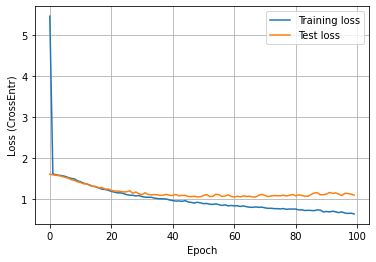

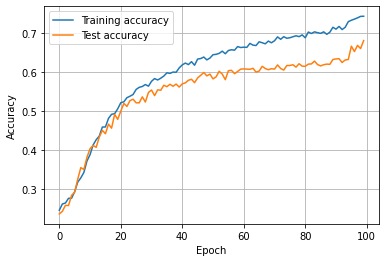

Train:
 Predicted      BITSTREAMVERA   CENTURY  CONSOLAS    EBRIMA      GILL
Actual                                                              
BITSTREAMVERA       0.834501  0.000000  0.023181  0.002156  0.140162
CENTURY             0.009248  0.827990  0.042540  0.025894  0.094328
CONSOLAS            0.025598  0.012243  0.846411  0.033389  0.082359
EBRIMA              0.017467  0.016012  0.125182  0.794032  0.047307
GILL                0.074074  0.012059  0.123170  0.012059  0.778639 
global:  0.8204635676783198

Test:
 Predicted      BITSTREAMVERA   CENTURY  CONSOLAS    EBRIMA      GILL
Actual                                                              
BITSTREAMVERA       0.750567  0.006803  0.070295  0.006803  0.165533
CENTURY             0.005305  0.790451  0.053050  0.058355  0.092838
CONSOLAS            0.057377  0.045082  0.655738  0.137295  0.104508
EBRIMA              0.060172  0.068768  0.206304  0.575931  0.088825
GILL                0.147651  0.033557  0.151007  0.060403

In [7]:
model = models.Sequential()
model.add(layers.Conv2D(16, (5, 5), activation='relu', input_shape=(20, 20, 1)))
model.add(layers.MaxPooling2D((2, 2), strides= 2))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides= 2))
model.add(layers.Flatten())
model.add(layers.Dense(90, activation='relu')) 
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))
#model.summary()

checkpointer = ModelCheckpoint('modelh_90', monitor='val_accuracy', save_best_only=True)
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
monitor = model.fit(x_train, tf.one_hot(pd.Series(y_train,dtype='category').astype('category').cat.codes,5), epochs=100, batch_size= int(len(train)**0.5),
                    validation_data=(x_test, tf.one_hot(pd.Series(y_test, dtype='category').astype('category').cat.codes,5)), callbacks=[checkpointer])


print('h=90:\n');plotCrssEntr(monitor); plotAcc(monitor)

trainConf, trainGlobal = conf(y_train, ypred(x_train, monitor.model))
print('Train:\n', trainConf,'\nGlobal: ', trainGlobal)

testConf, testGlobal = conf(y_test, ypred(x_test, monitor.model))
print('\nTest:\n', testConf, '\nGlobal: ', testGlobal)

h=150

Epoch 1/100
89/89 [==============================] - 3s 25ms/step - loss: 13.2162 - accuracy: 0.2416 - val_loss: 1.5536 - val_accuracy: 0.2970
INFO:tensorflow:Assets written to: modelh_150/assets
Epoch 2/100
89/89 [==============================] - 2s 23ms/step - loss: 1.5861 - accuracy: 0.2991 - val_loss: 1.5050 - val_accuracy: 0.3364
INFO:tensorflow:Assets written to: modelh_150/assets
Epoch 3/100
89/89 [==============================] - 2s 22ms/step - loss: 1.5317 - accuracy: 0.3274 - val_loss: 1.4823 - val_accuracy: 0.3605
INFO:tensorflow:Assets written to: modelh_150/assets
Epoch 4/100
89/89 [==============================] - 2s 22ms/step - loss: 1.4713 - accuracy: 0.3536 - val_loss: 1.4418 - val_accuracy: 0.3784
INFO:tensorflow:Assets written to: modelh_150/assets
Epoch 5/100
89/89 [==============================] - 2s 22ms/step - loss: 1.4347 - accuracy: 0.3948 - val_loss: 1.3963 - val_accuracy: 0.4107
INFO:tensorflow:Assets written to: modelh_150/assets
Epoch 6/100
89/89 [=====

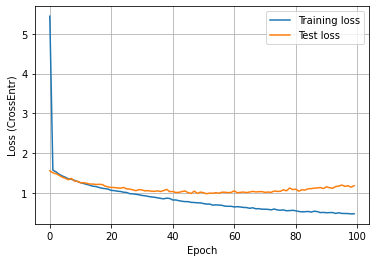

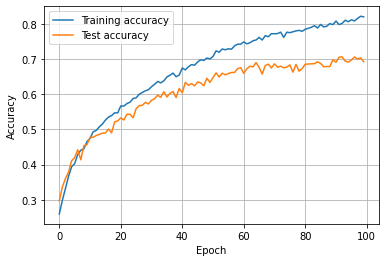

Train:
 Predicted      BITSTREAMVERA   CENTURY  CONSOLAS    EBRIMA      GILL
Actual                                                              
BITSTREAMVERA       0.860377  0.001078  0.004852  0.000539  0.133154
CENTURY             0.007398  0.895191  0.012947  0.006165  0.078298
CONSOLAS            0.033945  0.013356  0.869226  0.009460  0.074012
EBRIMA              0.017467  0.024017  0.053130  0.848617  0.056769
GILL                0.054264  0.008613  0.021533  0.001723  0.913867 
Global:  0.8755282366500192

Test:
 Predicted      BITSTREAMVERA   CENTURY  CONSOLAS    EBRIMA      GILL
Actual                                                              
BITSTREAMVERA       0.791383  0.004535  0.031746  0.006803  0.165533
CENTURY             0.015915  0.819629  0.053050  0.042440  0.068966
CONSOLAS            0.071721  0.065574  0.655738  0.090164  0.116803
EBRIMA              0.042980  0.114613  0.220630  0.501433  0.120344
GILL                0.154362  0.046980  0.090604  0.036913

In [9]:
model = models.Sequential()
model.add(layers.Conv2D(16, (5, 5), activation='relu', input_shape=(20, 20, 1)))
model.add(layers.MaxPooling2D((2, 2), strides= 2))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides= 2))
model.add(layers.Flatten())
model.add(layers.Dense(150, activation='relu')) 
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))
#model.summary()

checkpointer = ModelCheckpoint('modelh_150', monitor='val_accuracy', save_best_only=True)
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
monitor = model.fit(x_train, tf.one_hot(pd.Series(y_train,dtype='category').astype('category').cat.codes,5), epochs=100, batch_size= int(len(train)**0.5),
                    validation_data=(x_test, tf.one_hot(pd.Series(y_test, dtype='category').astype('category').cat.codes,5)), callbacks=[checkpointer])

print('h=150:\n'); plotCrssEntr(monitor); plotAcc(monitor)

trainConf, trainGlobal = conf(y_train, ypred(x_train, monitor.model))
print('Train:\n', trainConf,'\nGlobal: ', trainGlobal)

testConf, testGlobal = conf(y_test, ypred(x_test, monitor.model))
print('\nTest:\n', testConf, '\nGlobal: ', testGlobal)